In [1]:
import os
DATA_IDR='/kaggle/input/animefacedataset'
print(os.listdir(DATA_IDR))

['images']


In [2]:
print(os.listdir(DATA_IDR+'/images')[:10])

['35715_2011.jpg', '48610_2014.jpg', '34719_2011.jpg', '40266_2012.jpg', '4199_2002.jpg', '40739_2013.jpg', '42515_2013.jpg', '52482_2015.jpg', '46555_2014.jpg', '11579_2005.jpg']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size=64
batch_size=128
states=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [5]:
transforms=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*states)
])

train_ds=ImageFolder(DATA_IDR,transform=transforms)
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
#to denormalize so that we can print images
def denorm(img_tensor):
    return img_tensor*states[1][0]+states[0][0]#bring back to 0-1 range

In [8]:

def show_images(image,nmax=64):#takes a bunch of image tensors and plot them in a grid
    fig, ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(image.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):#we fetch one batch and break out
    for images,_ in dl:
        show_images(images,nmax)
        break

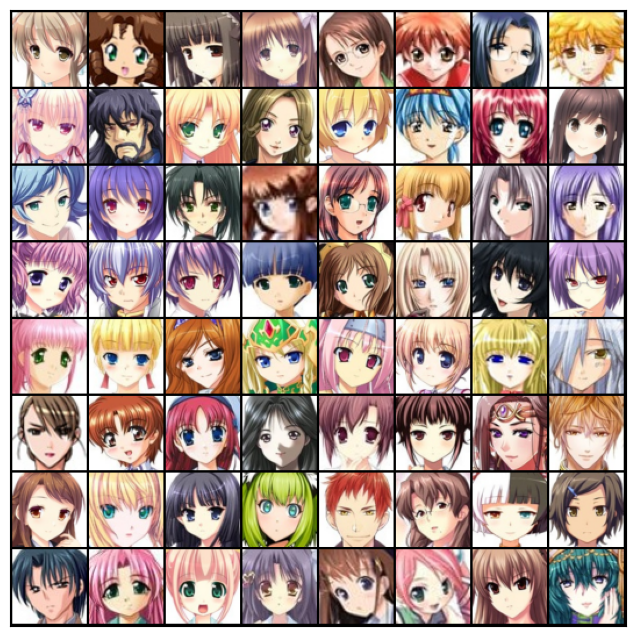

In [9]:
show_batch(train_dl)

In [10]:
!pip install jovian --upgrade --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.4 MB/s eta 0:00:00


In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):#move tensor to device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
            return len(self.dl)
        
        

In [12]:
device=get_default_device()
device

device(type='cuda')

In [13]:
train_dl=DeviceDataLoader(train_dl,device)

In [14]:
import torch.nn as nn

In [15]:
#discriminator model
discriminator=nn.Sequential(
    #in=3*64*64(size of 1 img in the batch)
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),#a=0.2 neg no. multi with 0.2
    #out=64*32*32

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    #out=256*8*8
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    #out=512*4*4(the filer is 4*4 which fits perfectly and reduces it 1*1 feature map)

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    #out=1*1*1(going to 1 channel)(1*1 tensor)
    #we reduce thefeature map to a single number

    nn.Flatten(),#flatten it to one vector
    nn.Sigmoid()#we have a single class
)


In [16]:
discriminator=to_device(discriminator,device)

In [17]:
latent_size=128

###GENERATOR

In [18]:
generator=nn.Sequential(
    #in=latent_size*1*1(one of many in a batch)

    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out=512*4*4
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out=256*8*8
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out=128*16*16

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out=64*32*32

    
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    
    
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


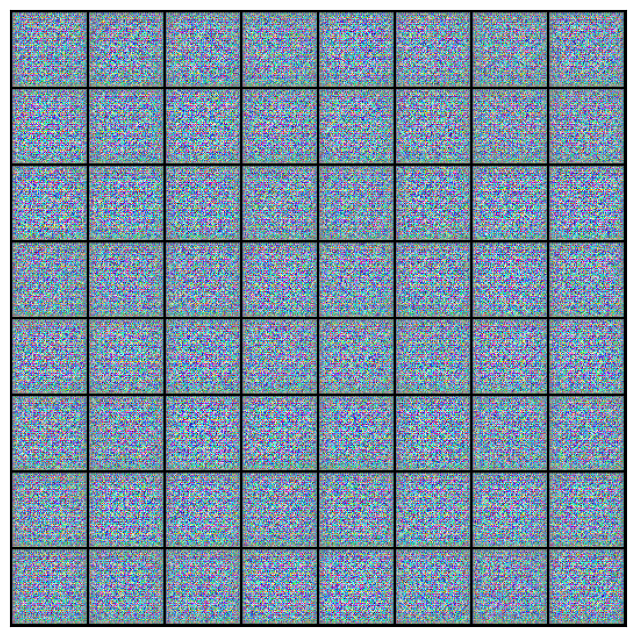

In [19]:
xb=torch.randn(batch_size,latent_size,1,1)#creats randon latent tensor with value btw -1 to 1(128,128,1,1)
fake_images=generator(xb)
print(xb.shape)
print(fake_images.shape)
show_images(fake_images)#normalize the to 0 to 1 range
#gives random noise

In [20]:
generator=to_device(generator,device)

TRAINING DISCRIMINATOR

In [21]:
def train_discriminator(real_images,opt_d):
    #clear discriminator gradients
    opt_d.zero_grad()

    #pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets=torch.ones(real_images.size(0),1,device=device)

    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    #generate fake img with same size
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    #pass fake images through discriminator
    #for the target net to be 0 cause dic. need to pred 0 for generated
    fake_preds = discriminator(fake_images.detach())
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

#update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()#computes gradient of the loss wrt to every single weight of the dis
    opt_d.step()#dis optimizer modifies the weights of the dis only make them better so that it becomes better at telling fake to real img

    return loss.item(), real_score, fake_score

In [22]:
def train_generator(opt_g):
    #output a img we use dis as part of loss function
    opt_g.zero_grad()#wipes out all the gradients

    latent=torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images=generator(latent)

    #try to fool the dis
    preds=discriminator(fake_images)
    targets=torch.ones(batch_size,1,device=device)#target set to 1
    loss=F.binary_cross_entropy(preds,targets)

    #update generator
    loss.backward()
    opt_g.step()

    return loss.item()

In [23]:
from torchvision.utils import save_image

In [24]:
#after every epoch we save a batch of images
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [25]:
def save_samples(index,latent_tensors,show=True):
    #generates a bunch of fake images 
    fake_images=generator(latent_tensors)
    fake_fname='generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
    print('Saving',fake_fname)

    if show:
        fig,ax=plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))
        

In [26]:
fixed_latent=torch.randn(64,latent_size,1,1,device=device)


Saving generated-images-0000.png


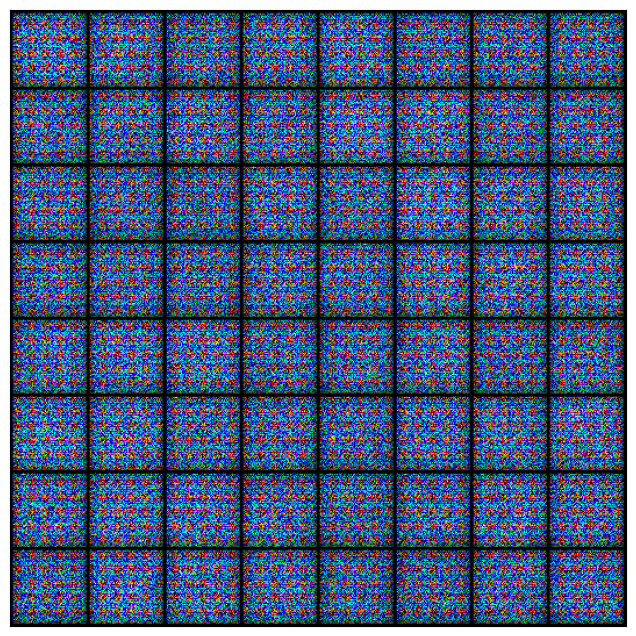

In [27]:
save_samples(0,fixed_latent)

In [28]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [29]:
def fit(epochs,lr,start_idx=1):
    torch.cuda.empty_cache()

    #loss & scores
    losses_g=[]
    losses_d=[]
    real_scores=[]
    fake_scores=[]

    #create optimizers
    opt_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            #train discriminator
            loss_d,real_score,fake_score=train_discriminator(real_images,opt_d)
            #train generator
            for _ in range(3):  # Train generator 3 times per discriminator update
                loss_g = train_generator(opt_g)

        #record losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
              epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx,fixed_latent,show=False)

    return losses_g,losses_d,real_scores,fake_scores
        
        

In [30]:
lr=0.0002
epochs=70

In [31]:
history=fit(epochs,lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/70], loss_g: 0.7182, loss_d: 1.3892, real_score: 0.5402, fake_score: 0.5339
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/70], loss_g: 0.7096, loss_d: 1.4219, real_score: 0.4661, fake_score: 0.4801
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/70], loss_g: 0.6379, loss_d: 1.4348, real_score: 0.5152, fake_score: 0.5369
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/70], loss_g: 0.6779, loss_d: 1.4168, real_score: 0.4888, fake_score: 0.5037
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/70], loss_g: 0.7538, loss_d: 1.4249, real_score: 0.4833, fake_score: 0.5015
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/70], loss_g: 0.6398, loss_d: 1.4052, real_score: 0.5027, fake_score: 0.5086
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/70], loss_g: 0.6941, loss_d: 1.4290, real_score: 0.5038, fake_score: 0.5222
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/70], loss_g: 0.6730, loss_d: 1.4089, real_score: 0.4816, fake_score: 0.4920
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/70], loss_g: 0.6332, loss_d: 1.4106, real_score: 0.4710, fake_score: 0.4813
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/70], loss_g: 0.7141, loss_d: 1.3929, real_score: 0.5109, fake_score: 0.5122
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/70], loss_g: 0.7167, loss_d: 1.3908, real_score: 0.4902, fake_score: 0.4898
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/70], loss_g: 0.9243, loss_d: 1.3853, real_score: 0.5391, fake_score: 0.5318
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/70], loss_g: 0.3003, loss_d: 1.3684, real_score: 0.3933, fake_score: 0.3382
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/70], loss_g: 0.7087, loss_d: 1.3475, real_score: 0.4503, fake_score: 0.4078
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/70], loss_g: 1.8329, loss_d: 1.4827, real_score: 0.8490, fake_score: 0.7187
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/70], loss_g: 1.5009, loss_d: 1.0144, real_score: 0.7830, fake_score: 0.5118
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/70], loss_g: 1.8122, loss_d: 0.9394, real_score: 0.6376, fake_score: 0.3530
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/70], loss_g: 1.4460, loss_d: 0.6980, real_score: 0.6607, fake_score: 0.2180
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/70], loss_g: 0.5040, loss_d: 0.9839, real_score: 0.4479, fake_score: 0.0998
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/70], loss_g: 0.9032, loss_d: 1.1817, real_score: 0.3733, fake_score: 0.0401
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/70], loss_g: 1.2234, loss_d: 0.9077, real_score: 0.6369, fake_score: 0.3039
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/70], loss_g: 1.2323, loss_d: 0.5690, real_score: 0.6815, fake_score: 0.1314
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/70], loss_g: 2.9772, loss_d: 0.8175, real_score: 0.9278, fake_score: 0.4829
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/70], loss_g: 3.3598, loss_d: 0.4782, real_score: 0.8902, fake_score: 0.2724
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/70], loss_g: 1.0718, loss_d: 0.4864, real_score: 0.7178, fake_score: 0.1104
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/70], loss_g: 2.7029, loss_d: 0.2676, real_score: 0.8784, fake_score: 0.1150
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/70], loss_g: 4.3782, loss_d: 0.6041, real_score: 0.9818, fake_score: 0.3929
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/70], loss_g: 2.2886, loss_d: 0.2991, real_score: 0.8958, fake_score: 0.1552
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/70], loss_g: 3.3746, loss_d: 0.3098, real_score: 0.9519, fake_score: 0.2047
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/70], loss_g: 1.3650, loss_d: 0.4793, real_score: 0.6801, fake_score: 0.0403
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/70], loss_g: 1.8871, loss_d: 0.3612, real_score: 0.7596, fake_score: 0.0477
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/70], loss_g: 3.4773, loss_d: 0.3461, real_score: 0.9344, fake_score: 0.2151
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/70], loss_g: 2.8967, loss_d: 0.2470, real_score: 0.9295, fake_score: 0.1372
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/70], loss_g: 1.2001, loss_d: 0.4743, real_score: 0.7032, fake_score: 0.0561
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/70], loss_g: 3.2966, loss_d: 0.3357, real_score: 0.8925, fake_score: 0.1683
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/70], loss_g: 4.0083, loss_d: 0.1702, real_score: 0.9560, fake_score: 0.1047
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/70], loss_g: 3.8202, loss_d: 0.1281, real_score: 0.9439, fake_score: 0.0638
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/70], loss_g: 5.4845, loss_d: 0.4288, real_score: 0.9796, fake_score: 0.2927
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/70], loss_g: 3.5500, loss_d: 0.1272, real_score: 0.9540, fake_score: 0.0707
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/70], loss_g: 2.8121, loss_d: 0.1870, real_score: 0.8779, fake_score: 0.0408
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/70], loss_g: 1.8233, loss_d: 0.2722, real_score: 0.8008, fake_score: 0.0090
Saving generated-images-0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/70], loss_g: 4.6782, loss_d: 0.1259, real_score: 0.9642, fake_score: 0.0787
Saving generated-images-0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/70], loss_g: 4.5759, loss_d: 0.3802, real_score: 0.9589, fake_score: 0.2542
Saving generated-images-0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/70], loss_g: 1.4292, loss_d: 0.5093, real_score: 0.7570, fake_score: 0.1055
Saving generated-images-0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/70], loss_g: 4.1398, loss_d: 0.1443, real_score: 0.9011, fake_score: 0.0315
Saving generated-images-0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/70], loss_g: 2.2360, loss_d: 0.5833, real_score: 0.6916, fake_score: 0.0797
Saving generated-images-0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/70], loss_g: 2.9411, loss_d: 0.2338, real_score: 0.9150, fake_score: 0.1053
Saving generated-images-0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/70], loss_g: 4.0313, loss_d: 0.1878, real_score: 0.8575, fake_score: 0.0160
Saving generated-images-0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/70], loss_g: 4.0537, loss_d: 0.1077, real_score: 0.9177, fake_score: 0.0162
Saving generated-images-0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/70], loss_g: 3.5996, loss_d: 0.4396, real_score: 0.9562, fake_score: 0.2688
Saving generated-images-0050.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [51/70], loss_g: 3.6393, loss_d: 0.1546, real_score: 0.9454, fake_score: 0.0793
Saving generated-images-0051.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [52/70], loss_g: 0.3655, loss_d: 2.4447, real_score: 0.1580, fake_score: 0.0003
Saving generated-images-0052.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [53/70], loss_g: 3.3770, loss_d: 0.4559, real_score: 0.9810, fake_score: 0.2945
Saving generated-images-0053.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [54/70], loss_g: 4.1939, loss_d: 0.2182, real_score: 0.9185, fake_score: 0.0975
Saving generated-images-0054.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [55/70], loss_g: 3.6665, loss_d: 0.6980, real_score: 0.5892, fake_score: 0.0032
Saving generated-images-0055.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [56/70], loss_g: 4.7707, loss_d: 0.0644, real_score: 0.9751, fake_score: 0.0360
Saving generated-images-0056.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [57/70], loss_g: 4.5733, loss_d: 0.2186, real_score: 0.9470, fake_score: 0.1330
Saving generated-images-0057.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [58/70], loss_g: 4.3420, loss_d: 0.2260, real_score: 0.9555, fake_score: 0.1440
Saving generated-images-0058.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [59/70], loss_g: 5.1805, loss_d: 0.3336, real_score: 0.9794, fake_score: 0.2168
Saving generated-images-0059.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [60/70], loss_g: 3.3117, loss_d: 0.2214, real_score: 0.8426, fake_score: 0.0170
Saving generated-images-0060.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [61/70], loss_g: 4.4741, loss_d: 0.0948, real_score: 0.9261, fake_score: 0.0142
Saving generated-images-0061.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [62/70], loss_g: 4.6870, loss_d: 0.0993, real_score: 0.9874, fake_score: 0.0748
Saving generated-images-0062.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [63/70], loss_g: 3.2712, loss_d: 0.1811, real_score: 0.8690, fake_score: 0.0246
Saving generated-images-0063.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [64/70], loss_g: 4.8255, loss_d: 0.0759, real_score: 0.9738, fake_score: 0.0433
Saving generated-images-0064.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [65/70], loss_g: 0.0758, loss_d: 3.0745, real_score: 0.0978, fake_score: 0.0018
Saving generated-images-0065.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [66/70], loss_g: 3.8305, loss_d: 0.0435, real_score: 0.9806, fake_score: 0.0227
Saving generated-images-0066.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [67/70], loss_g: 5.1056, loss_d: 0.0922, real_score: 0.9828, fake_score: 0.0643
Saving generated-images-0067.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [68/70], loss_g: 3.2829, loss_d: 0.1910, real_score: 0.9160, fake_score: 0.0810
Saving generated-images-0068.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [69/70], loss_g: 5.1360, loss_d: 0.0753, real_score: 0.9848, fake_score: 0.0506
Saving generated-images-0069.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [70/70], loss_g: 5.1322, loss_d: 0.0818, real_score: 0.9841, fake_score: 0.0595
Saving generated-images-0070.png


In [32]:
losses_g,losses_d,real_scores,fake_scores=history

In [33]:
torch.save(generator.state_dict(),'G.pth')
torch.save(discriminator.state_dict(),'D.pth')

In [34]:
from IPython.display import Image

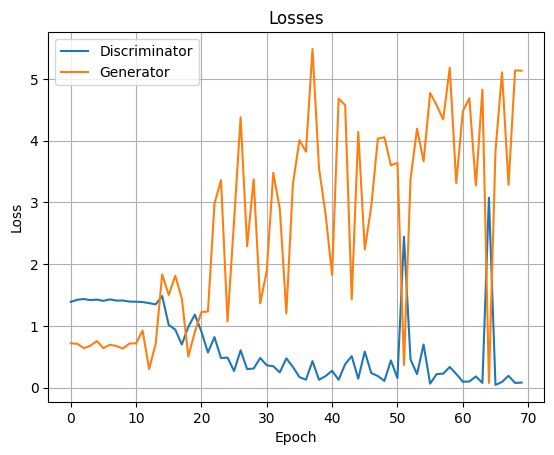

In [35]:

plt.plot(losses_d, label='Discriminator', linestyle='-')
plt.plot(losses_g, label='Generator', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.grid(True)
plt.show()